# <span style="color:orange"> *Multiple subject optimization* </span> </br>
This version is computationally more efficient. It does no create nifti images, nor it relies on SCT for metric extraction </br>
This also uses the data of multiple subjects. </br>
This notebook also changes the demodulation approach.

We now create a demodulation to get the absolute frequency values from our imaged FMs and 

In [1]:
%matplotlib inline
import nibabel as nib
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import subprocess
import sys
import pandas as pd
import os

In [2]:
path_to_chi_to_fm_fft = "C:/Users/User/msc_project/susceptibility-to-fieldmap-fft"
sys.path.append(path_to_chi_to_fm_fft)
#sys.path.append('/Users/evaalonsoortiz/Documents/python/susceptibility-to-fieldmap-fft/')
from functions import compute_fieldmap

## <span style="color:gold"> *Lets first plot both our Measured and get the avg* </span> 

In [20]:
path_to_avg_resp_33 = r"E:/msc_data/ismrm_2025/dB0_033_dup1/fm/C_dmod_meas/simple_avg_respiration.csv"
avg_33_resp_b0meas_metrics_csv = pd.read_csv(path_to_avg_resp_33)
avg_33_resp_b0meas_values = avg_33_resp_b0meas_metrics_csv["WA()"]

path_to_avg_resp_32 = r"E:/msc_data/ismrm_2025/db0_032/fm/C_dmod_meas/simple_avg_respiration.csv"
avg_32_resp_b0meas_metrics_csv = pd.read_csv(path_to_avg_resp_32)
avg_32_resp_b0meas_values = avg_32_resp_b0meas_metrics_csv["WA()"]

path_to_avg_resp_35 = r"E:/msc_data/ismrm_2025/dB0_035/fm/C_dmod_meas/simple_avg_respiration.csv"
avg_35_resp_b0meas_metrics_csv = pd.read_csv(path_to_avg_resp_35)
avg_35_resp_b0meas_values = avg_35_resp_b0meas_metrics_csv["WA()"]


In [4]:
path_to_re_avg_32 = "E:/msc_data/ismrm_2025/db0_032/fm/C_dmod_meas/simple_avg_respiration.csv"
avg_32_resp_b0meas_metrics_csv = pd.read_csv(path_to_re_avg_32)
avg_32_resp_b0meas_values = avg_32_resp_b0meas_metrics_csv["WA()"]

### Range of FM metrics
- dB0_032 -> from C4 to T8 (vert 4 to 15)
- dB0_033 -> from C4 to T7 (vert 3 to 14)
- dB0_035 -> from C4 to T7 (vert 4 to 14)

In [11]:
db0_33_vals = avg_33_resp_b0meas_values
db0_33_vals

0    -110.888410
1     -53.312953
2      14.442740
3      93.797890
4     127.060660
5      79.966874
6      47.420091
7      45.571511
8      49.048168
9      48.554811
10     35.809311
Name: WA(), dtype: float64

In [12]:
db0_32_vals = avg_32_resp_b0meas_values[:-2]
db0_32_vals

0    -120.366184
1    -100.056767
2     -42.013446
3      43.314191
4     104.134758
5      67.827829
6     -12.573064
7     -30.862036
8     -10.427612
9      17.335520
10     25.933529
Name: WA(), dtype: float64

In [19]:
db0_35_vals = avg_35_resp_b0meas_values
db0_35_vals

0    -86.727411
1    -74.811855
2    -36.277499
3     23.813495
4     82.638355
5     72.294822
6     48.810360
7     45.322720
8     58.677333
9     59.936366
10    22.478234
Name: WA(), dtype: float64

In [23]:
avg_meas_all_subjects = (db0_35_vals + db0_33_vals + db0_32_vals)/3
avg_meas_all_subjects

0    -105.994001
1     -76.060525
2     -21.282735
3      53.641859
4     104.611258
5      73.363175
6      27.885795
7      20.010732
8      32.432630
9      41.942232
10     28.073691
Name: WA(), dtype: float64

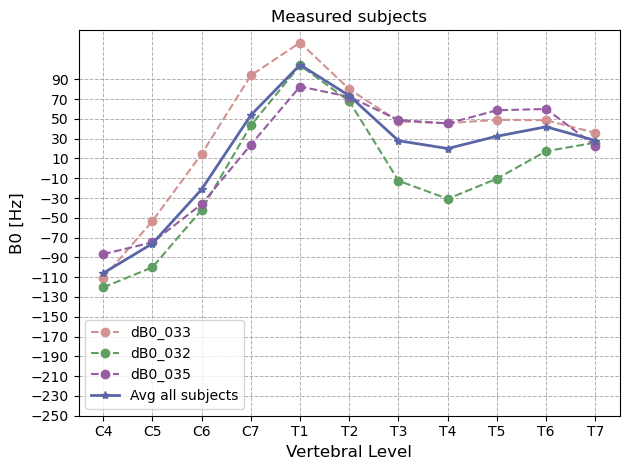

In [27]:
vertebrae_levels = ['C4','C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6','T7'] 
# ['C4','C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6','T7','T8'] 

plt.plot(vertebrae_levels, db0_33_vals, marker = 'o', linestyle = '--', label = "dB0_033", color = "#D29292")  
plt.plot(vertebrae_levels, db0_32_vals, marker = 'o', linestyle = '--', label = "dB0_032", color = "#5F9F62") 
plt.plot(vertebrae_levels, db0_35_vals, marker = 'o', linestyle = '--', label = "dB0_035", color = "#965CA4")
plt.plot(vertebrae_levels, avg_meas_all_subjects, marker = '*', linestyle = '-', linewidth = 2, label = "Avg all subjects", color = "#5A66A7") 

plt.title("Measured subjects")
plt.xlabel('Vertebral Level', fontsize=12)
plt.ylabel('B0 [Hz]', fontsize=12)
plt.legend()

yticks = range(-250, 101, 20) 
plt.yticks(yticks)

plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()

# Show the plot
plt.show()

## <span style="color:gold"> *Now lets load the simulation information* </span> 

In [8]:
path_to_sim_32_metric_mask = "E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz"
path_to_32_dmod_mask = "E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz"
path_to_32_chimap = "E:/msc_data/ismrm_2025/db0_032/fm/sim/B1_chi_maps/db0_032_sus_opt_map.nii.gz" # -4.36 (past value)
path_to_32_segs = "E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/grouped_wb_segs.nii.gz"

counter = 0 

path_to_33_sim_metric_mask = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz"
path_to_33_dmod_mask = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz"
path_to_33_chimap = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/B1_chi_maps/dB0_033_mod0.nii.gz" # -4.36 (past value)
path_to_33_segs = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/final_merged_wb_segs.nii.gz"

In [9]:
    # Load the susceptibility distribution in ppm
sim_chi_img_32 = nib.load(path_to_32_chimap)
sim_chi_data_32 = sim_chi_img_32.get_fdata()

sim_chi_img_33 = nib.load(path_to_33_chimap)
sim_chi_data_33 = sim_chi_img_33.get_fdata()

    # Load segmentation labels that create the chimaps
ROI_img_32 = nib.load(path_to_32_segs)
ROI_data_32 = ROI_img_32.get_fdata()

ROI_img_33 = nib.load(path_to_33_segs)
ROI_data_33 = ROI_img_33.get_fdata()

    # Now we load the demodulation mask, which in this case is also the Spinal cord mask, can change
dmod_mask_img_32 = nib.load(path_to_32_dmod_mask)
dmod_mask_data_32 = dmod_mask_img_32.get_fdata()

dmod_mask_img_33 = nib.load(path_to_33_dmod_mask)
dmod_mask_data_33 = dmod_mask_img_33.get_fdata()

    # Find indices with the labels we want to iterate!
ind_trachea_32 = np.where((ROI_data_32 == 8))
ind_lungs_32 = np.where((ROI_data_32 == 7))

ind_trachea_33 = np.where((ROI_data_33 == 8))
ind_lungs_33 = np.where((ROI_data_33 == 7))

In [10]:
def f_habemus(x):

    global counter # This works? 
    
    counter += 1  
    print('################')
    print(f"Iteration #{counter}")
    print(f"Current values of variables: x[0] = {x[0]} & x[1] = {x[1]}")
    print(f"Current values of variables: x[2] = {x[2]} & x[3] = {x[3]}")
    #print(f"Current values of variables: x[0] = {x[0]}, x[1] = {x[1]} & x[2] = {x[2]}")
    
    sim_chi_data_32[ind_trachea_32] = x[0]
    sim_chi_data_32[ind_lungs_32] = x[1]

    sim_chi_data_33[ind_trachea_33] = x[2] 
    sim_chi_data_33[ind_lungs_33] = x[3] 

    # Now we gotta compute the B0 distribution in [ppm] using compute_bz from repository
    # Lets load the chi map with load_sus_dist from compute fieldmap to get the image res for FBFest
    chi_dist, image_res_32, affine_matrix = compute_fieldmap.load_sus_dist(path_to_32_chimap)
    chi_dist, image_res_33, affine_matrix = compute_fieldmap.load_sus_dist(path_to_33_chimap)

    sim_b0_ppm_32 =  compute_fieldmap.compute_bz(sim_chi_data_32, image_resolution = image_res_32)
    sim_b0_ppm_33 =  compute_fieldmap.compute_bz(sim_chi_data_33, image_resolution = image_res_33)
    # bz will be in [ppm] we go to Hz now

    sim_b0_Hz_32 = sim_b0_ppm_32 * 3 * 42.58 # deltaB0 [Hz] = dB0 [ppm] * 1e-6  * B0 [T] * 42.58* e6 [Hz/T] 
    sim_b0_Hz_33 = sim_b0_ppm_33 * 3 * 42.58

    # Chi[odd] trachea and Chi[even] lung
    # This are the values in ppm with reference to the void 

    # Just in case you want to check the chimaps created: ###################################
    #chi_map_name = f"chimap_tr_{chi1_name}_l_{chi2_name}_Hz.nii.gz"
    # Load where you want to save them, and dont forget to use the same run number :)
    # And don't forget to actually create the run# folder 
    #path_to_iterchimaps = "E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/chimaps_extra/run13"
    #chimap_img = nib.Nifti1Image(sim_chi_data, affine = sim_chi_img.affine)
    #chimap_save_dir = os.path.join(path_to_iterchimaps, chi_map_name)
    #nib.save(chimap_img, chimap_save_dir)
    ##########################################################################################

    #dmod_fm_name = f"dmod_sim_fm_tr_{chi1_name}_l_{chi2_name}_Hz.nii.gz" # First lets try 2, then 3 different for body with IMC prior
    #dmod_fm_name = f"dmod_sim_fm_tr_{chi1_name}_l_{chi2_name}_bd_{chi3_name}_Hz.nii.gz"
    #path_to_dmod_fm = os.path.join(path_to_iter_dmod_fms, dmod_fm_name)

    # Now we need to demodulated the fieldmap 

    dmod_value_32 = np.mean(sim_b0_Hz_32[dmod_mask_data_32 == 1])
    dmod_value_33 = np.mean(sim_b0_Hz_33[dmod_mask_data_33 == 1])

    print("Demod value for Simulation 32: ", dmod_value_32)
    print("Demod value for Simulation 33: ", dmod_value_33)

    dmod_sim_b0_Hz_32 = sim_b0_Hz_32 - dmod_value_32
    dmod_sim_b0_Hz_33 = sim_b0_Hz_33 - dmod_value_33

    # This demodulation factor affects the range of chi value so we need to adjust for that
    # We need to put the dmod value in PPM for changing the ppm value for chi air and chi lung

    chi_adjust_32 = dmod_value_32/(3*42.58)
    chi_adjust_33 = dmod_value_33/(3*42.58)

    print("Adjustemn value in [ppm] for sim_32: ", chi_adjust_32)
    print("Adjustemn value in [ppm] for sim_33: ", chi_adjust_33)

    # Assign variables after correcting for shift due to dmodulation


    #sim_chi_data[ind_body] = x[2]
    #sim_chi_data[ind_bone] = x[3]

    print("Demodulation complete ... ")

    print("Actual chi values after adjustment: ")
    print(f"For dB0_032: chi_tr : {x[0]+chi_adjust_32} & chi_lung : {x[1]+chi_adjust_32}")
    print(f"For dB0_033: chi_tr : {x[2]+chi_adjust_33} & chi_lung : {x[3]+chi_adjust_33}")
    # Now we extract metrics 
    #metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_Hz.csv"
    #metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_bd_{chi3_name}_Hz.csv"
    #path_to_out_metrics = os.path.join(path_to_iter_metrics,metrics_name)

    #extract_metrics(path_to_dmod_fm, path_to_dmod_mask, path_to_sim_metric_mask, path_to_out_metrics, method='wa', vert="3:15")

    #metric_values = pd.read_csv(path_to_out_metrics)
    #dmod_sim_vert_values = metric_values['WA()'][::-1]
    
    # Now, new code to extract metrics without SCT dependency

    metric_data_32 = []
    metric_data_33 = []

    # Load metric masks to find the intersection
    metric_mask_img_32 = nib.load(path_to_sim_32_metric_mask)
    metric_mask_img_33 = nib.load(path_to_33_sim_metric_mask)

    metric_mask_data_32 = metric_mask_img_32.get_fdata()
    metric_mask_data_33 = metric_mask_img_33.get_fdata()

    # First lets find the intersection of labels between them,
    # In order to plot properly without missing data points

    intersect_mask_range = np.intersect1d(metric_mask_data_32, metric_mask_data_33)

    for i in intersect_mask_range:
        if i == 0:
            continue # Ignore the background

        mask_indices_32 = metric_mask_data_32 == i
        mask_indices_33 = metric_mask_data_33 == i

        mean_value_32 = np.mean(dmod_sim_b0_Hz_32[mask_indices_32])
        mean_value_33 = np.mean(dmod_sim_b0_Hz_33[mask_indices_33])

        metric_data_32.append((mean_value_32))
        metric_data_33.append((mean_value_33))

        #print(mean_value_32)
        #print(mean_value_33)

        # This will be sorted from C3 to T6 or T8 depending on the range
    # In this case the intersection is from C3 to the 16th vert
    metric_data_32 = metric_data_32[1:-1]
    metric_data_33 = metric_data_33[2::]
    # Now lets average the metrics and perform the optimization
    
    average_simulation_values = (metric_data_32 + metric_data_33)
    list_of_sim_values = [metric_data_32, metric_data_33]

    average_simulated_values = [sum(elements)/len(elements) for elements in zip(*list_of_sim_values)]
    adjusted_x = [x[0]+chi_adjust_32, x[1]+chi_adjust_32 , x[2]+chi_adjust_33 , x[3]+chi_adjust_33]
    print(adjusted_x)
    difference = np.linalg.norm(avg_meas_all_subjects - average_simulated_values)
    lambd = 1
    p1 = 4
    std_xj = np.std(adjusted_x)
    print("Std of adjusted chi values: ",std_xj)
    part2 = lambd * np.linalg.norm(std_xj - p1)
    difference = difference + part2
    print("Minimizing: ",difference)

    return difference

In [11]:
# Set initial values, boundaries and run optimization
initial_values = [-1, -3, 0.5 , 0.5] # Body should begin
# First bound is trachea
# Second bound is Lung
bounds = [(-2, 1), (-5, 1), (-2, 1), (-5, 1)]

result = optimize.minimize(f_habemus, initial_values, bounds = bounds, method = 'Nelder-Mead')

################
Iteration #1
Current values of variables: x[0] = 0.3 & x[1] = 0.3
Current values of variables: x[2] = 0.3 & x[3] = 0.3
Demod value for Simulation 32:  -270.80665093052914
Demod value for Simulation 33:  -389.963757266652
Adjustemn value in [ppm] for sim_32:  -2.1199831762214587
Adjustemn value in [ppm] for sim_33:  -3.052792839100141
Demodulation complete ... 
Actual chi values after adjustment: 
For dB0_032: chi_tr : -1.8199831762214587 & chi_lung : -1.8199831762214587
For dB0_033: chi_tr : -2.7527928391001413 & chi_lung : -2.7527928391001413
[np.float64(-1.8199831762214587), np.float64(-1.8199831762214587), np.float64(-2.7527928391001413), np.float64(-2.7527928391001413)]
Std of adjusted chi values:  0.4664048314393413
Minimizing:  139.63092663662187
################
Iteration #2
Current values of variables: x[0] = 0.315 & x[1] = 0.3
Current values of variables: x[2] = 0.3 & x[3] = 0.3
Demod value for Simulation 32:  -282.48972737539526
Demod value for Simulation 33:

KeyboardInterrupt: 

In [12]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 143.73978994004088
             x: [ 1.000e+00 -5.000e+00  1.000e+00 -5.000e+00]
           nit: 36
          nfev: 62
 final_simplex: (array([[ 1.000e+00, -5.000e+00,  1.000e+00, -5.000e+00],
                       [ 1.000e+00, -5.000e+00,  1.000e+00, -5.000e+00],
                       ...,
                       [ 1.000e+00, -5.000e+00,  1.000e+00, -5.000e+00],
                       [ 1.000e+00, -5.000e+00,  1.000e+00, -5.000e+00]],
                      shape=(5, 4)), array([ 1.437e+02,  1.437e+02,  1.437e+02,  1.437e+02,
                        1.437e+02]))

In [16]:
# Manually trying metric extraction as matrix
# Lets test with db0_032

metric_mask_img = nib.load(path_to_sim_32_metric_mask)
metric_mask_data = metric_mask_img.get_fdata()

metric_mask_data2 = nib.load(path_to_33_sim_metric_mask).get_fdata()

fm_img = nib.load("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run24/dmod_sim_fm_tr_-2_0_l_1_0_Hz.nii.gz")
fm_data = fm_img.get_fdata()

# Now for each of the metric values we should get the average value

final_data = []
intersect_mask_range = np.intersect1d(metric_mask_data, metric_mask_data2)

for i in intersect_mask_range:
    if i == 0:
        continue # To skip bg
    mask_indices = metric_mask_data == i
    mean_value = np.mean(fm_data[mask_indices])
    final_data.append((mean_value))
    # Because it goes from 3 to XX then its ordered alread
    

print(np.linalg.norm(avg_meas_all_subjects - final_data[1:-1]))
x = [0.3, 0.3, 0.3 ,0.3]
difference = np.linalg.norm(avg_meas_all_subjects - final_data[1:-1])
# For the intra subject variability
lambd = 10 # Weihting factor, because data in ppm for chi dist is in ppm units, but magnitude -10 to 10
# As well as the 
rn = 4 # Max range of values allowed
std_xj = np.std(x)
part2 = lambd * np.linalg.norm(std_xj - rn)
difference = difference + part2

difference

171.10358996117355


np.float64(211.10358996117355)

In [17]:
intersect_mask_range = np.intersect1d(metric_mask_data, metric_mask_data2)

intersect_mask_range

array([ 0.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16.])

In [21]:
np.unique(metric_mask_data)

array([ 0.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17.])

In [25]:
np.unique(metric_mask_data)[1:-1]

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
       16.])

In [20]:
np.unique(metric_mask_data2)

array([ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16.])

In [24]:
np.unique(metric_mask_data2)[2::]

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
       16.])